In [2]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

c:\Users\gunwo\miniconda3\envs\mlenv\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
location_model = load_model('CNN_location_model.keras')

In [4]:
def normalize_test_image():
    img_normalized = []
    folder_path = "./test_image"

    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        img_normalized.append(img)

    return np.array(img_normalized)

In [5]:
test_image_data = normalize_test_image()
test_image_data.shape

(1, 208, 267)

In [6]:
cropped_image_size = 80

test_data = []
test_data_coordinate = []
for img in test_image_data:
    for i in range(0, 186, 2):
        for j in range(0, 127, 2):
            test_image = img[i:i+cropped_image_size, j:j+cropped_image_size]
            test_image = cv2.resize(test_image, dsize=(50, 50))
            test_data.append(test_image)
            test_data_coordinate.append([j+int(cropped_image_size / 2), i+int(cropped_image_size / 2)])

In [7]:
test_data = np.array(test_data)

In [8]:
test_pred = location_model.predict(test_data)
test_pred

186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


array([[4.6279720e-24],
       [7.5609020e-16],
       [6.2626341e-25],
       ...,
       [6.7728586e-20],
       [8.4373155e-14],
       [6.1951153e-11]], dtype=float32)

In [9]:
test_pred = test_pred.flatten()

In [10]:
def group_assign_weights(arr, threshold=3):
    
    arr = np.sort(arr)
    weights = {}
    current_group = [arr[0]]

    for i in range(1, len(arr)):
        if arr[i] - arr[i-1] <= threshold:
            current_group.append(arr[i])
        else:
            weights[current_group[0]] = len(current_group)
            current_group = [arr[i]]

    weights[current_group[0]] = len(current_group)

    return weights

In [11]:
index_weight_dictionary = group_assign_weights(np.argsort(test_pred)[-10:])
final_index = max(index_weight_dictionary, key=index_weight_dictionary.get)

In [12]:
def show_predict_result(test_data_coordinate, center_x, center_y):

    # 이미지 불러오기 (흑백 이미지)
    image = test_image_data[0]

    # 흑백 이미지를 3채널 이미지로 변환 (BGR)
    image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # 사각형 크기 설정
    rect_size = 50
    half_size = rect_size // 2

    # 사각형의 왼쪽 상단 좌표 (top-left)와 오른쪽 하단 좌표 (bottom-right) 계산
    top_left = (center_x - half_size, center_y - half_size)
    bottom_right = (center_x + half_size, center_y + half_size)

    # 빨간색 사각형 그리기 (색상은 BGR로 설정, 빨간색은 (0, 0, 255))
    cv2.rectangle(image_colored, top_left, bottom_right, (0, 0, 255), 2)

    # 결과 이미지 보기
    cv2.imshow("predicted", image_colored)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [13]:
center_x = test_data_coordinate[final_index][0]
center_y = test_data_coordinate[final_index][1]

show_predict_result(test_data_coordinate, center_x, center_y)

In [14]:
rotation_model = load_model('CNN_rotation_model.keras')

In [15]:
crop_size = 80

half_crop_size = crop_size // 2
            
start_x = center_x - half_crop_size
start_y = center_y - half_crop_size
end_x = center_x + half_crop_size
end_y = center_y + half_crop_size

final_block_image = test_image_data[0][start_y:end_y, start_x:end_x]
final_block_image = np.array([cv2.resize(final_block_image, dsize=(50, 50))])

In [16]:
final_block_image.shape

(1, 50, 50)

In [17]:
cv2.imshow('img', final_block_image[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
rotation_model.predict(final_block_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([[9.9999726e-01, 2.1305618e-06, 5.4541056e-07]], dtype=float32)

In [19]:
rotation_pred = np.argmax(rotation_model.predict(final_block_image)) * 30
rotation_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


0

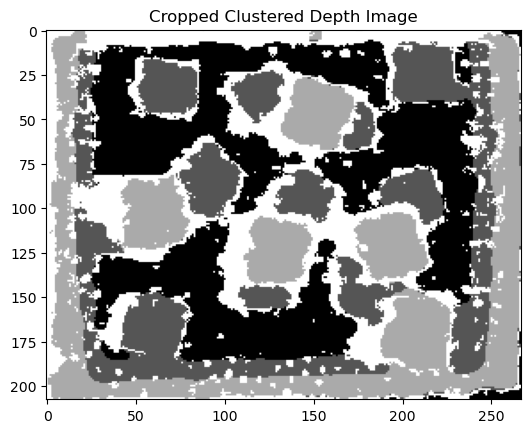

In [29]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 뎁스 이미지 불러오기
depth_image = cv2.imread('./test_image/test_image.png', cv2.IMREAD_GRAYSCALE)

# 2. 1차원으로 변환 (픽셀 벡터화)
pixels = depth_image.flatten().reshape(-1, 1)

# 3. KMeans 클러스터링 (클러스터 수 설정)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pixels)

# 4. 클러스터 라벨을 이미지 형식으로 다시 변환
clustered_img = kmeans.labels_.reshape(depth_image.shape)

# 5. 클러스터 중심값 확인
centroids = kmeans.cluster_centers_

# 6. 중심값을 기준으로 정렬된 인덱스 추출
sorted_indices = np.argsort(centroids.flatten())[::-1]  # 중심값 기준으로 정렬

# 7. 각 클러스터에 새로운 층 번호 부여
layered_img = np.zeros_like(clustered_img)
for layer_num, old_cluster_index in enumerate(sorted_indices):
    layered_img[clustered_img == old_cluster_index] = layer_num + 1

plt.imshow(layered_img, cmap='gray')
plt.title('Cropped Clustered Depth Image')
plt.show()

In [34]:
layered_img

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1]])

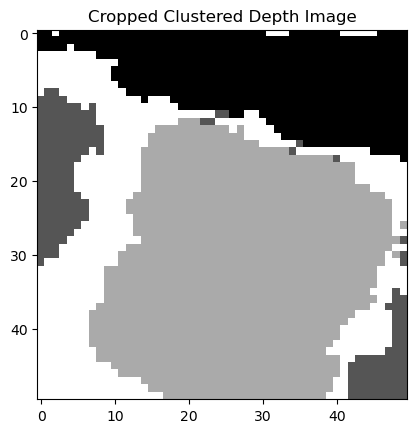

In [38]:
cropped_layer = layered_img[center_y-25:center_y+25, center_x-25:center_x+25]

plt.imshow(cropped_layer, cmap='gray')
plt.title('Cropped Clustered Depth Image')
plt.show()

In [39]:
# 0을 제외하고 unique 값과 counts를 계산
unique, counts = np.unique(cropped_layer[cropped_layer != 4], return_counts=True) # 흰색(원본 사진에서는 검정색) 제외하고 카운트, 검정은 어느 층에도 속하지 않음

dominant_layer = unique[np.argmax(counts)]

In [40]:
print('final prediction')
print('block location')
print(f'x : {center_x}, y : {center_y}, {dominant_layer} floor')
print(f'block rotated : {rotation_pred} degree')

final prediction
block location
x : 150, y : 40, 3 floor
block rotated : 0 degree
